![Sahabat Tani Group](https://i.imgur.com/BAu0r90.png)

# Training Model

---

[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/valselt/sahabat-tani-group)

YOLO11 builds on the advancements introduced in YOLOv9 and YOLOv10 earlier this year, incorporating improved architectural designs, enhanced feature extraction techniques, and optimized training methods.

YOLO11m achieves a higher mean mAP score on the COCO dataset while using 22% fewer parameters than YOLOv8m, making it computationally lighter without sacrificing performance.

YOLOv11 is available in 5 different sizes, ranging from `2.6M` to `56.9M` parameters, and capable of achieving from `39.5` to `54.7` mAP on the COCO dataset.

## Setup

### Configure API keys

To fine-tune YOLO11, you need to provide your Roboflow API key. Follow these steps:

- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

### Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

Thu Nov 21 06:32:07 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLO11 via Ultralytics

In [ ]:
%pip install ultralytics supervision roboflow
import ultralytics
ultralytics.checks()

Ultralytics 8.3.34 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.8/112.6 GB disk)


In [ ]:
!pip install inference

## Inference with model pre-trained on COCO dataset

### CLI

**NOTE:** CLI requires no customization or Python code. You can simply run all tasks from the terminal with the yolo command.

In [ ]:
!yolo task=detect mode=predict model=yolo11n.pt conf=0.25 source='https://cdn.britannica.com/16/187216-050-CB57A09B/tomatoes-tomato-plant-Fruit-vegetable.jpg' save=True

100% 5.35M/5.35M [00:00<00:00, 29.6MB/s]
Ultralytics 8.3.34 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n summary (fused): 238 layers, 2,616,248 parameters, 0 gradients, 6.5 GFLOPs

100% 140k/140k [00:00<00:00, 28.8MB/s]
image 1/1 /content/tomatoes-tomato-plant-Fruit-vegetable.jpg: 448x640 4 apples, 2 oranges, 57.3ms
Speed: 11.6ms preprocess, 57.3ms inference, 700.4ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


**NOTE:** Result annotated image got saved in `{HOME}/runs/detect/predict/`. Let's display it.

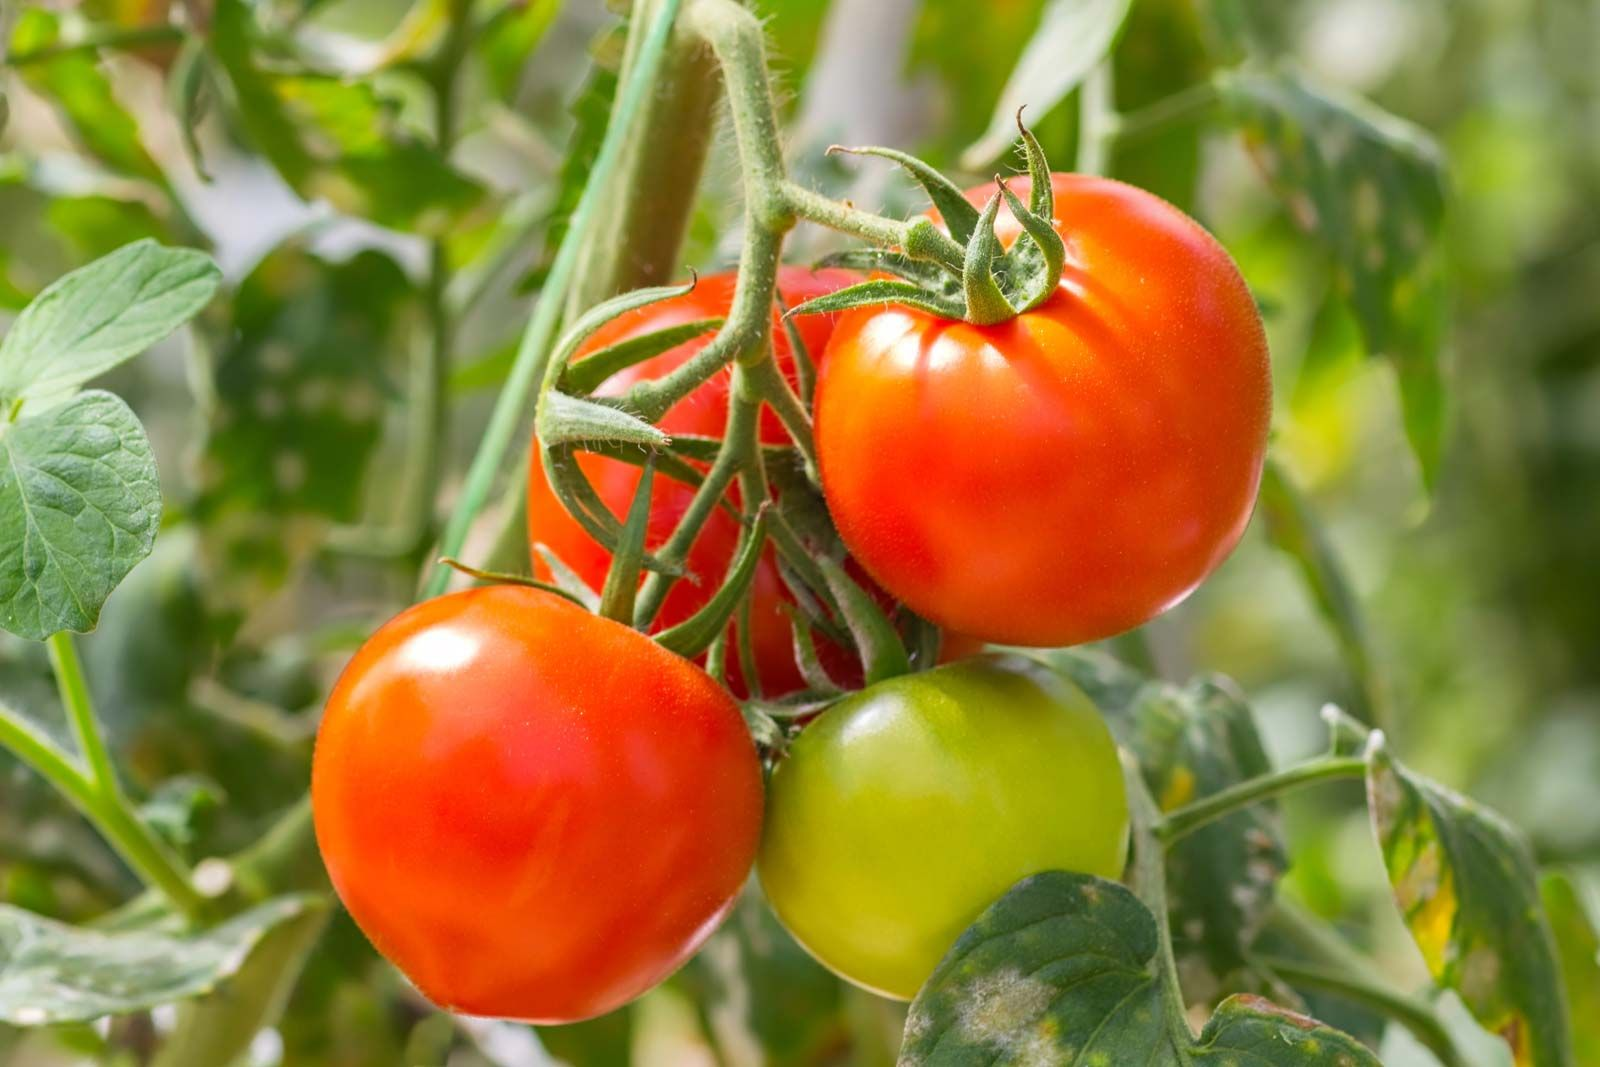

In [ ]:
from IPython.display import Image as IPyImage

path = f'{HOME}/tomatoes-tomato-plant-Fruit-vegetable.jpg'

IPyImage(filename=path, width=600)

### SDK

**NOTE:** YOLO's Python interface allows for seamless integration into your Python projects, making it easy to load, run, and process the model's output.

In [ ]:
from ultralytics import YOLO
from PIL import Image
import requests

model = YOLO('yolo11n.pt')
image = Image.open('tomatoes-tomato-plant-Fruit-vegetable.jpg')
result = model.predict(image, conf=0.25)[0]


0: 448x640 4 apples, 2 oranges, 51.3ms
Speed: 5.2ms preprocess, 51.3ms inference, 642.0ms postprocess per image at shape (1, 3, 448, 640)


**NOTE:** The obtained `result` object stores information about the location, classes, and confidence levels of the detected objects.

In [ ]:
result.boxes.xyxy

tensor([[ 310.2202,  578.6714,  765.1547, 1026.8958],
        [ 756.1998,  659.5045, 1129.7898, 1001.0257],
        [ 805.9866,  169.0651, 1275.0057,  652.9556],
        [ 807.2364,  172.4731, 1275.4115,  653.8635],
        [ 525.9648,  263.3604,  949.0358,  682.0239],
        [ 530.2227,  171.5682, 1271.3514,  667.6925]], device='cuda:0')

In [ ]:
result.boxes.conf

tensor([0.8434, 0.7561, 0.4831, 0.4620, 0.4081, 0.2884], device='cuda:0')

In [ ]:
result.boxes.cls

tensor([49., 47., 49., 47., 47., 47.], device='cuda:0')

**NOTE:** YOLO11 can be easily integrated with `supervision` using the familiar `from_ultralytics` connector.

In [ ]:
import supervision as sv

detections = sv.Detections.from_ultralytics(result)

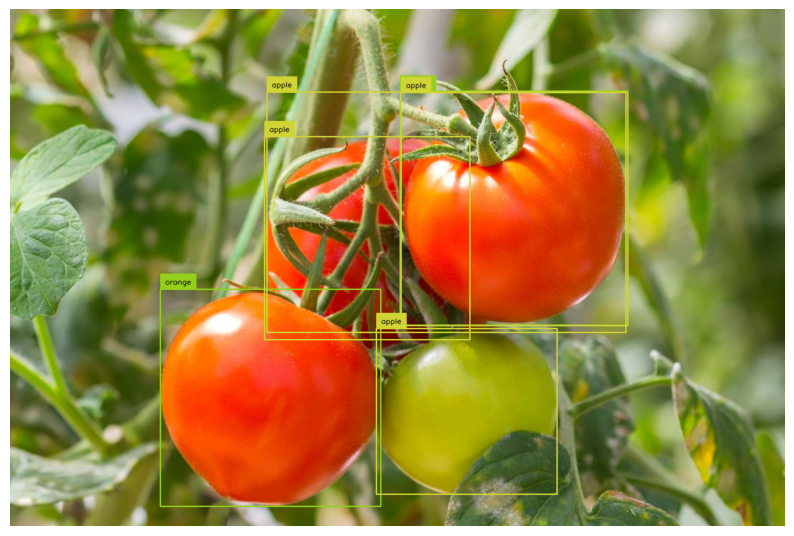

In [ ]:
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator(text_color=sv.Color.BLACK)

annotated_image = image.copy()
annotated_image = box_annotator.annotate(annotated_image, detections=detections)
annotated_image = label_annotator.annotate(annotated_image, detections=detections)

sv.plot_image(annotated_image, size=(10, 10))

## Fine-tune YOLO11 on custom dataset

**NOTE:** When training YOLOv11, make sure your data is located in `datasets`. If you'd like to change the default location of the data you want to use for fine-tuning, you can do so through Ultralytics' `settings.json`. In this tutorial, we will use one of the [datasets](https://universe.roboflow.com/liangdianzhong/-qvdww) available on [Roboflow Universe](https://universe.roboflow.com/). When downloading, make sure to select the `yolov11` export format.

In [ ]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

from google.colab import userdata
from roboflow import Roboflow

ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')
rf = Roboflow(api_key=ROBOFLOW_API_KEY)

workspace = rf.workspace("penelitian-lpgmn")
project = workspace.project("tomato-detection-fresh-or-rotten-using-yolov8")
version = project.version(1)
dataset = version.download("yolov11")

mkdir: cannot create directory ‘/content/datasets’: File exists
/content/datasets
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Tomato-Detection-Fresh-or-Rotten-using-YOLOv8-1 in yolov11:: 100%|██████████| 33540/33540 [00:05<00:00, 5884.18it/s]


## Custom Training

In [ ]:
%cd {HOME}

!yolo task=detect mode=train model=yolo11s.pt data={dataset.location}/data.yaml epochs=30 imgsz=640 plots=True

/content
Ultralytics 8.3.34 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=/content/datasets/Tomato-Detection-Fresh-or-Rotten-using-YOLOv8-1/data.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, sav

**NOTE:** The results of the completed training are saved in `{HOME}/runs/detect/train/`. Let's examine them.

In [ ]:
!ls {HOME}/runs/detect/train/

args.yaml					    PR_curve.png	   val_batch0_pred.jpg
confusion_matrix_normalized.png			    R_curve.png		   val_batch1_labels.jpg
confusion_matrix.png				    results.csv		   val_batch1_pred.jpg
events.out.tfevents.1732101617.c43e1d9ffc90.2446.0  results.png		   val_batch2_labels.jpg
F1_curve.png					    train_batch0.jpg	   val_batch2_pred.jpg
labels_correlogram.jpg				    train_batch1.jpg	   weights
labels.jpg					    train_batch2.jpg
P_curve.png					    val_batch0_labels.jpg


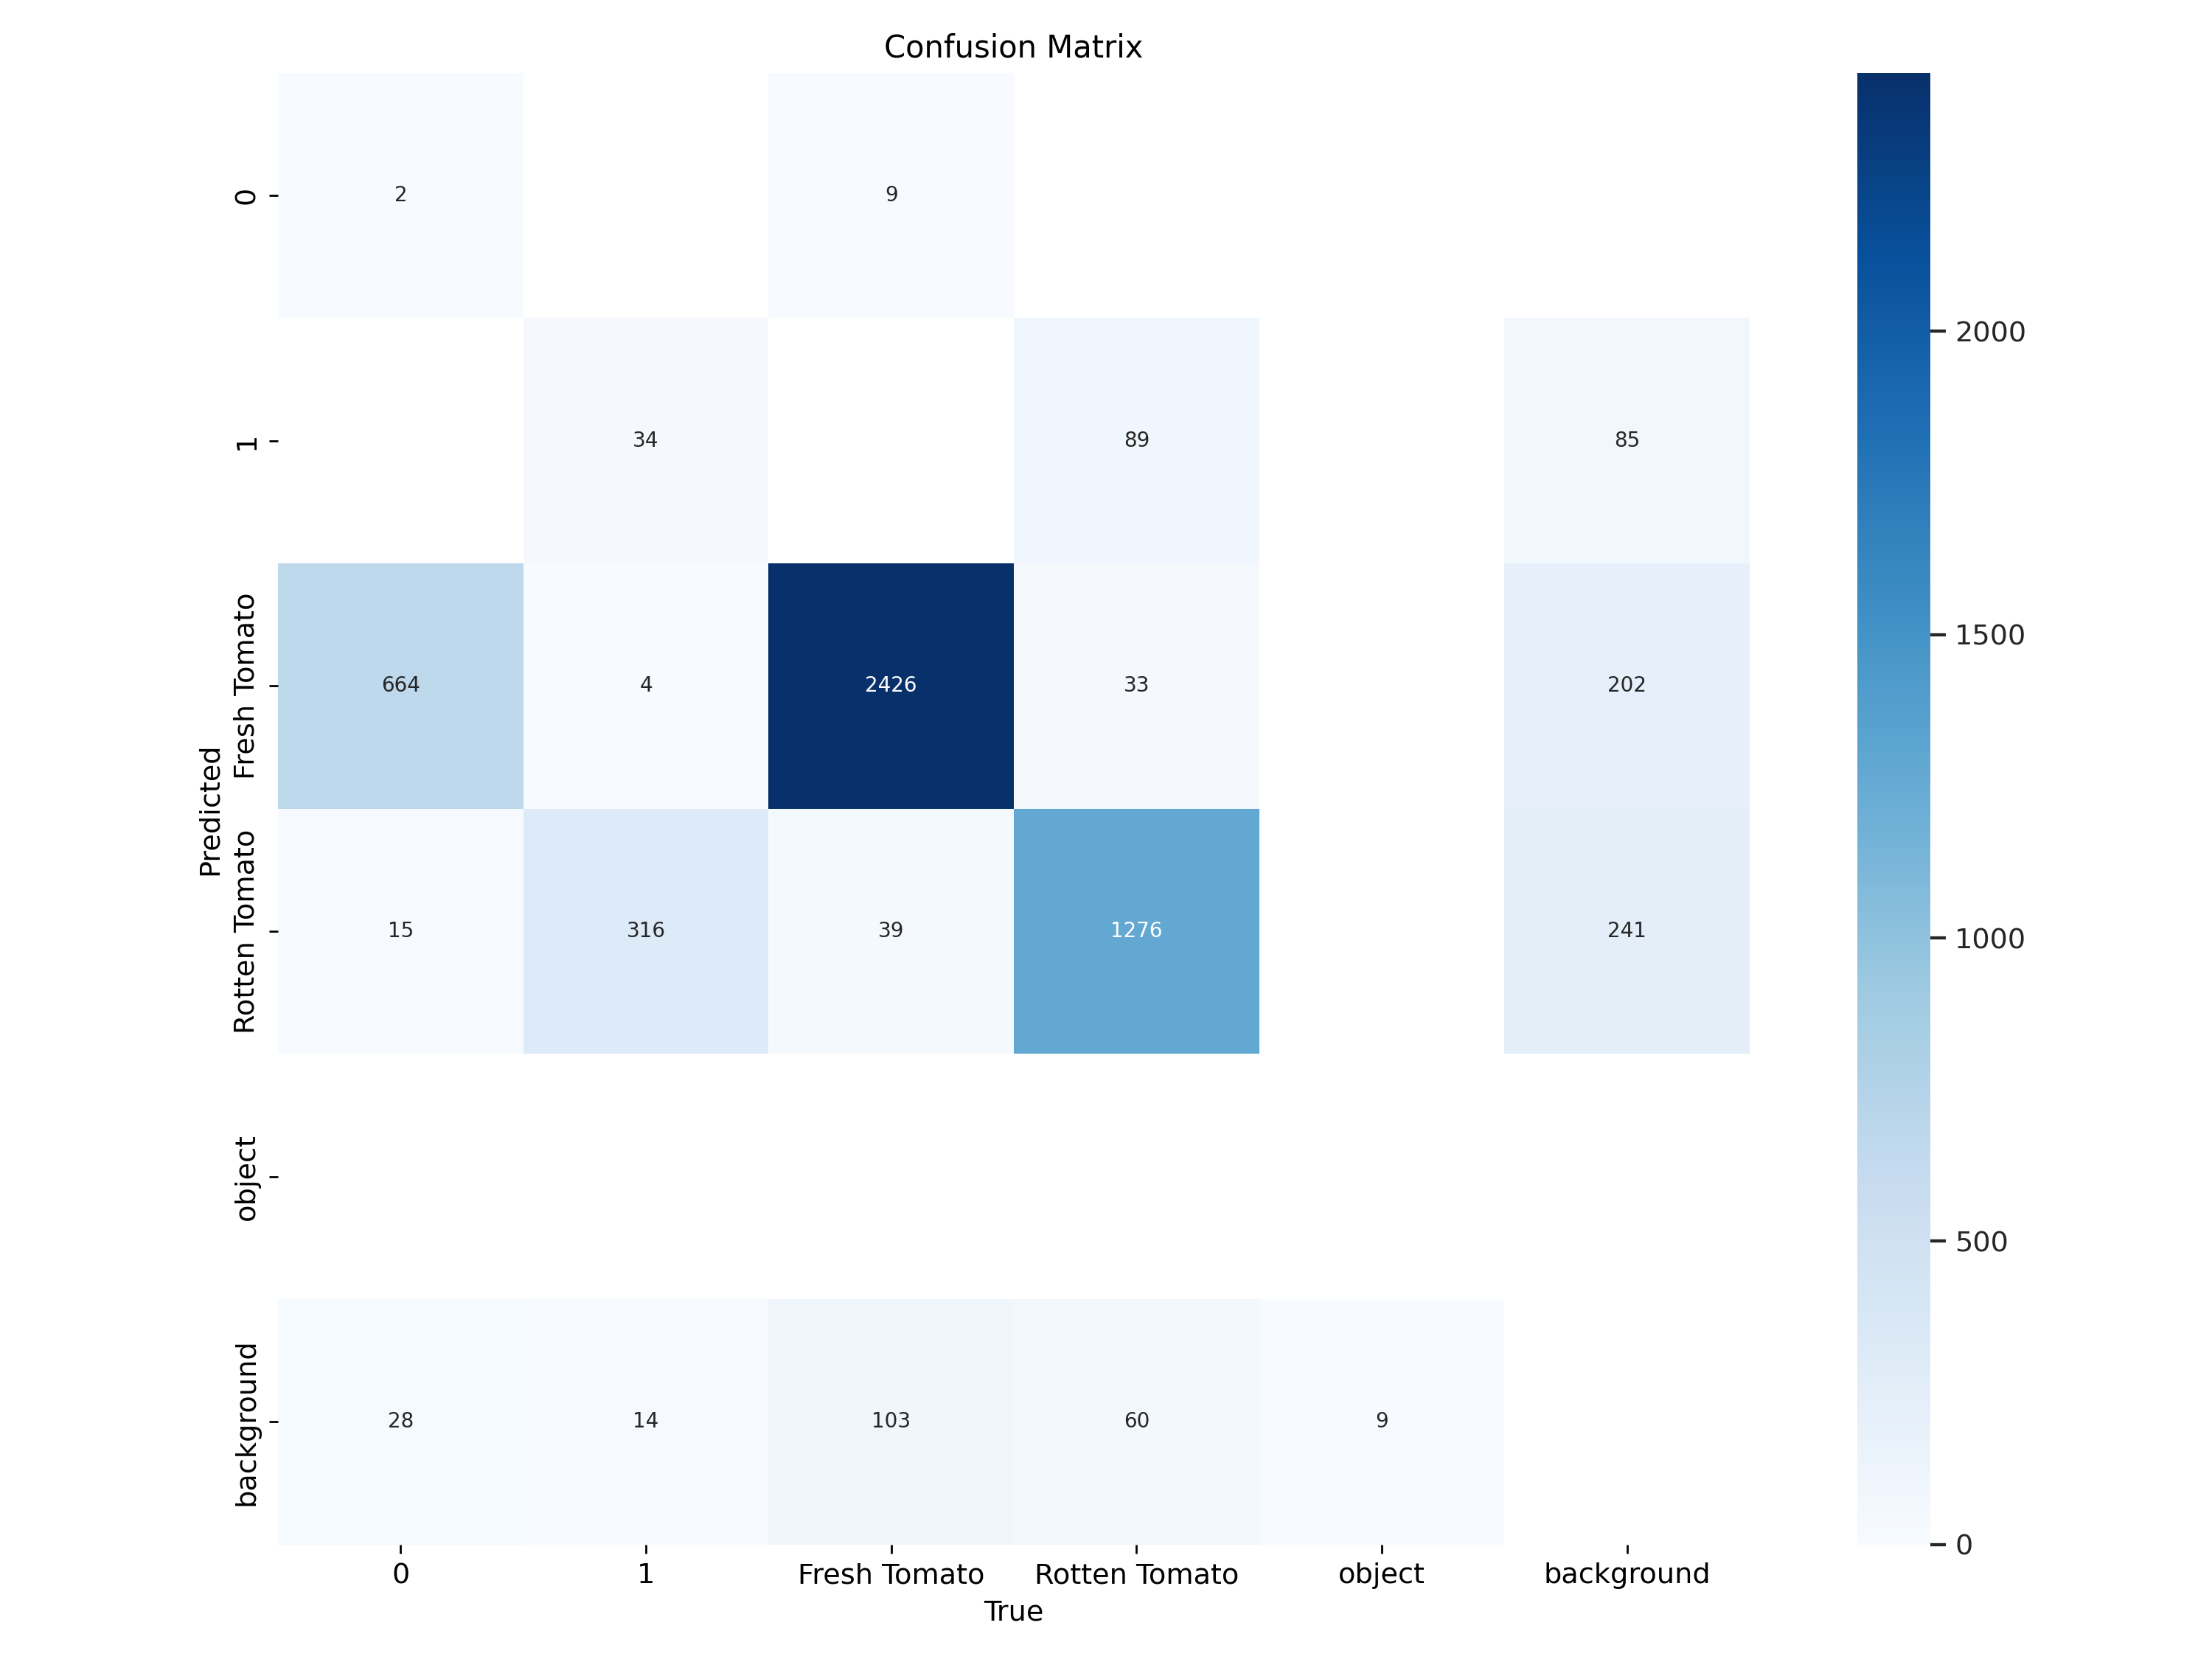

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

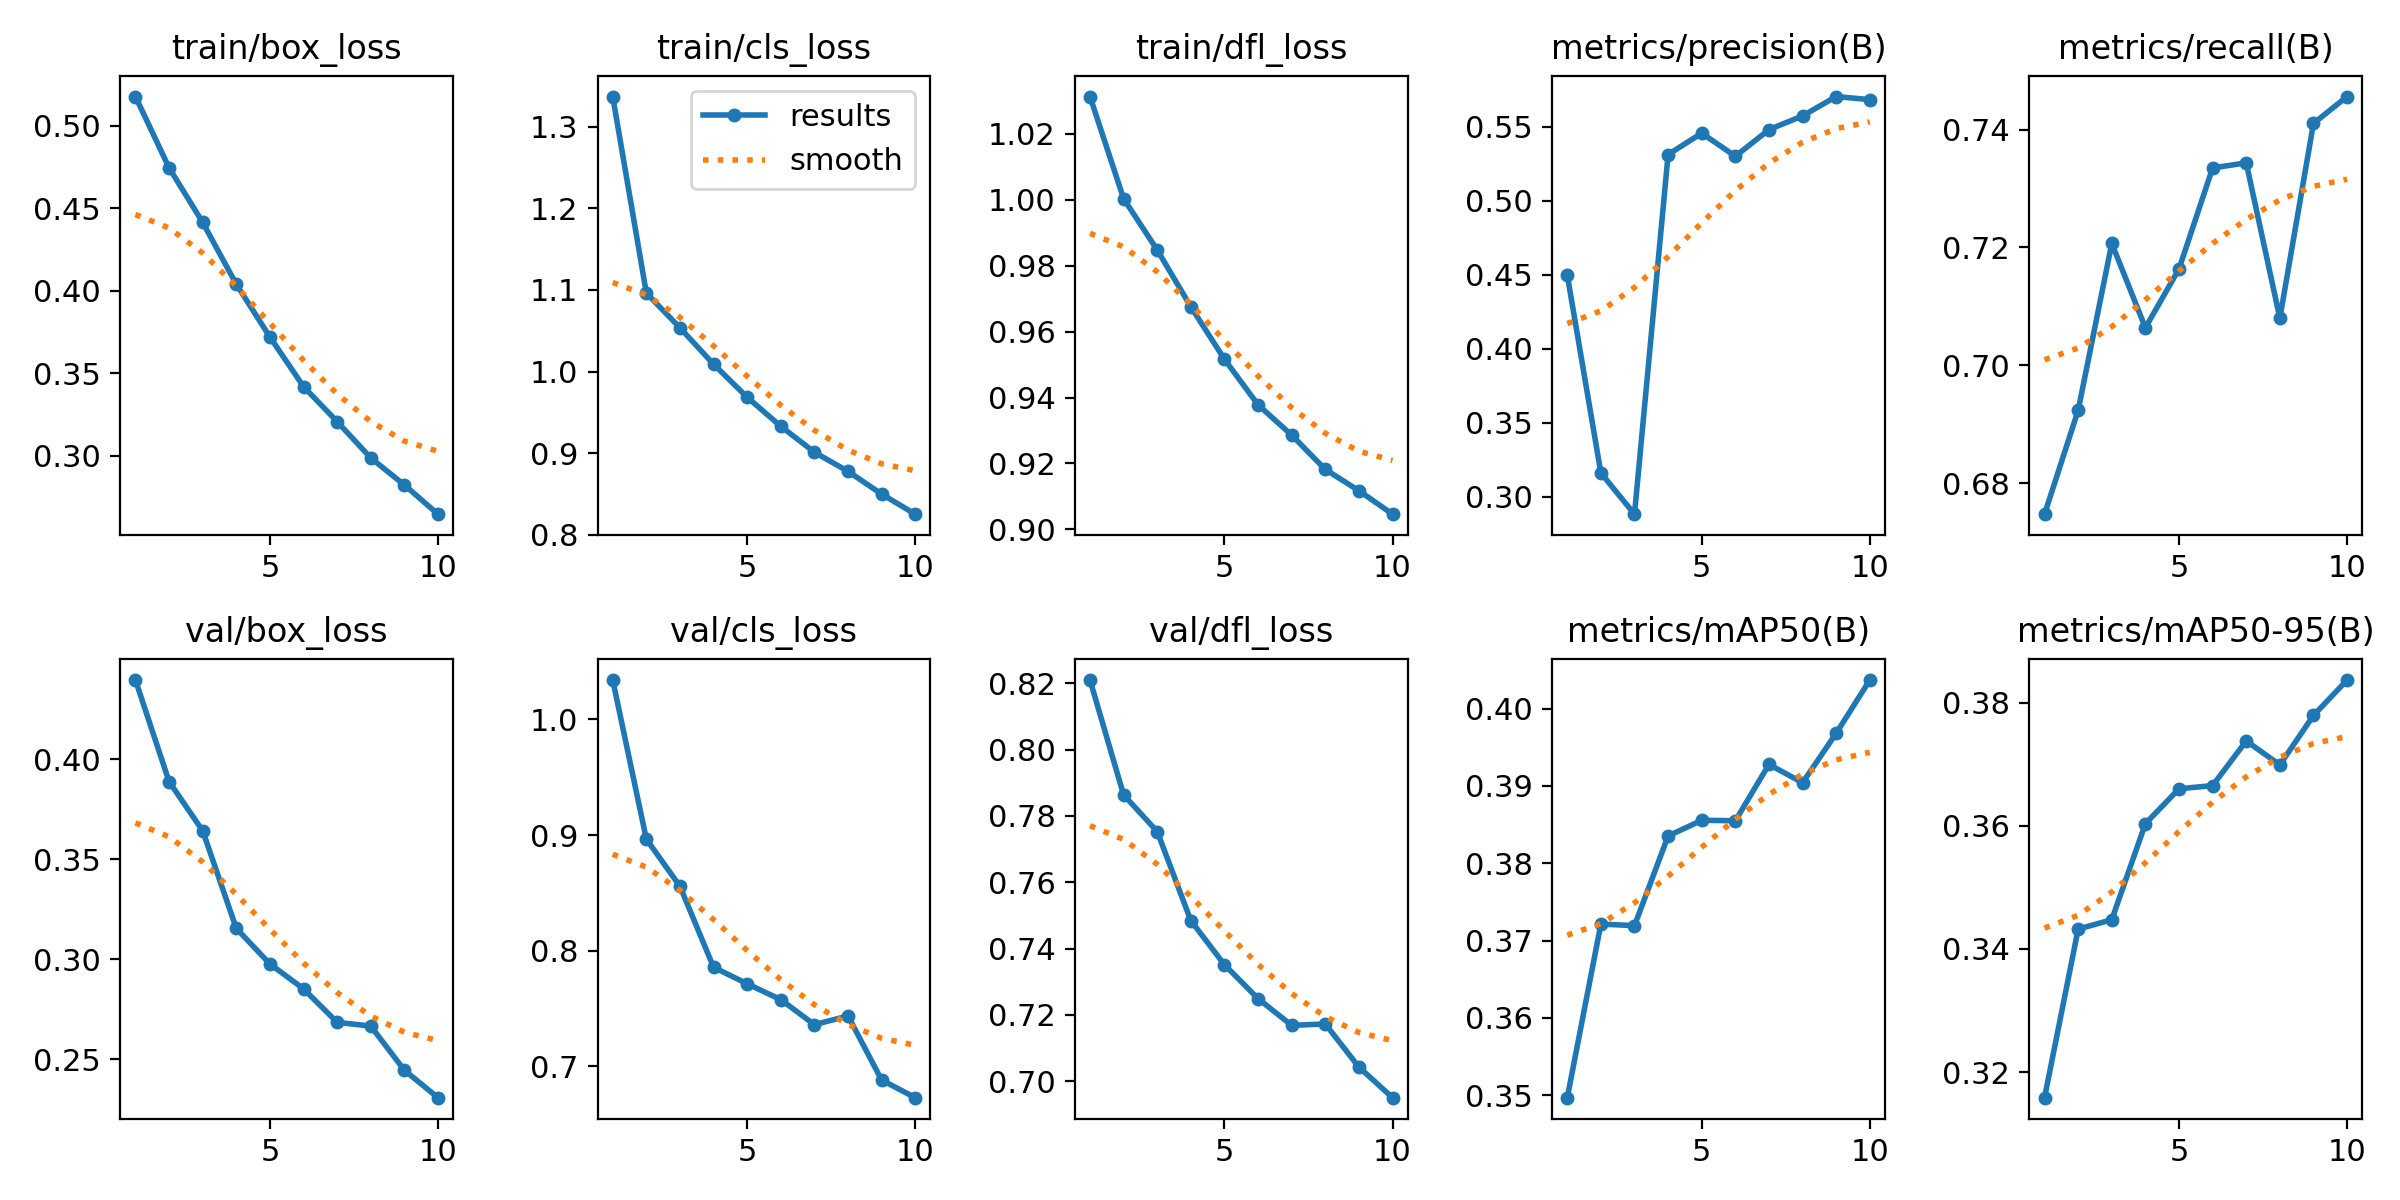

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/results.png', width=600)

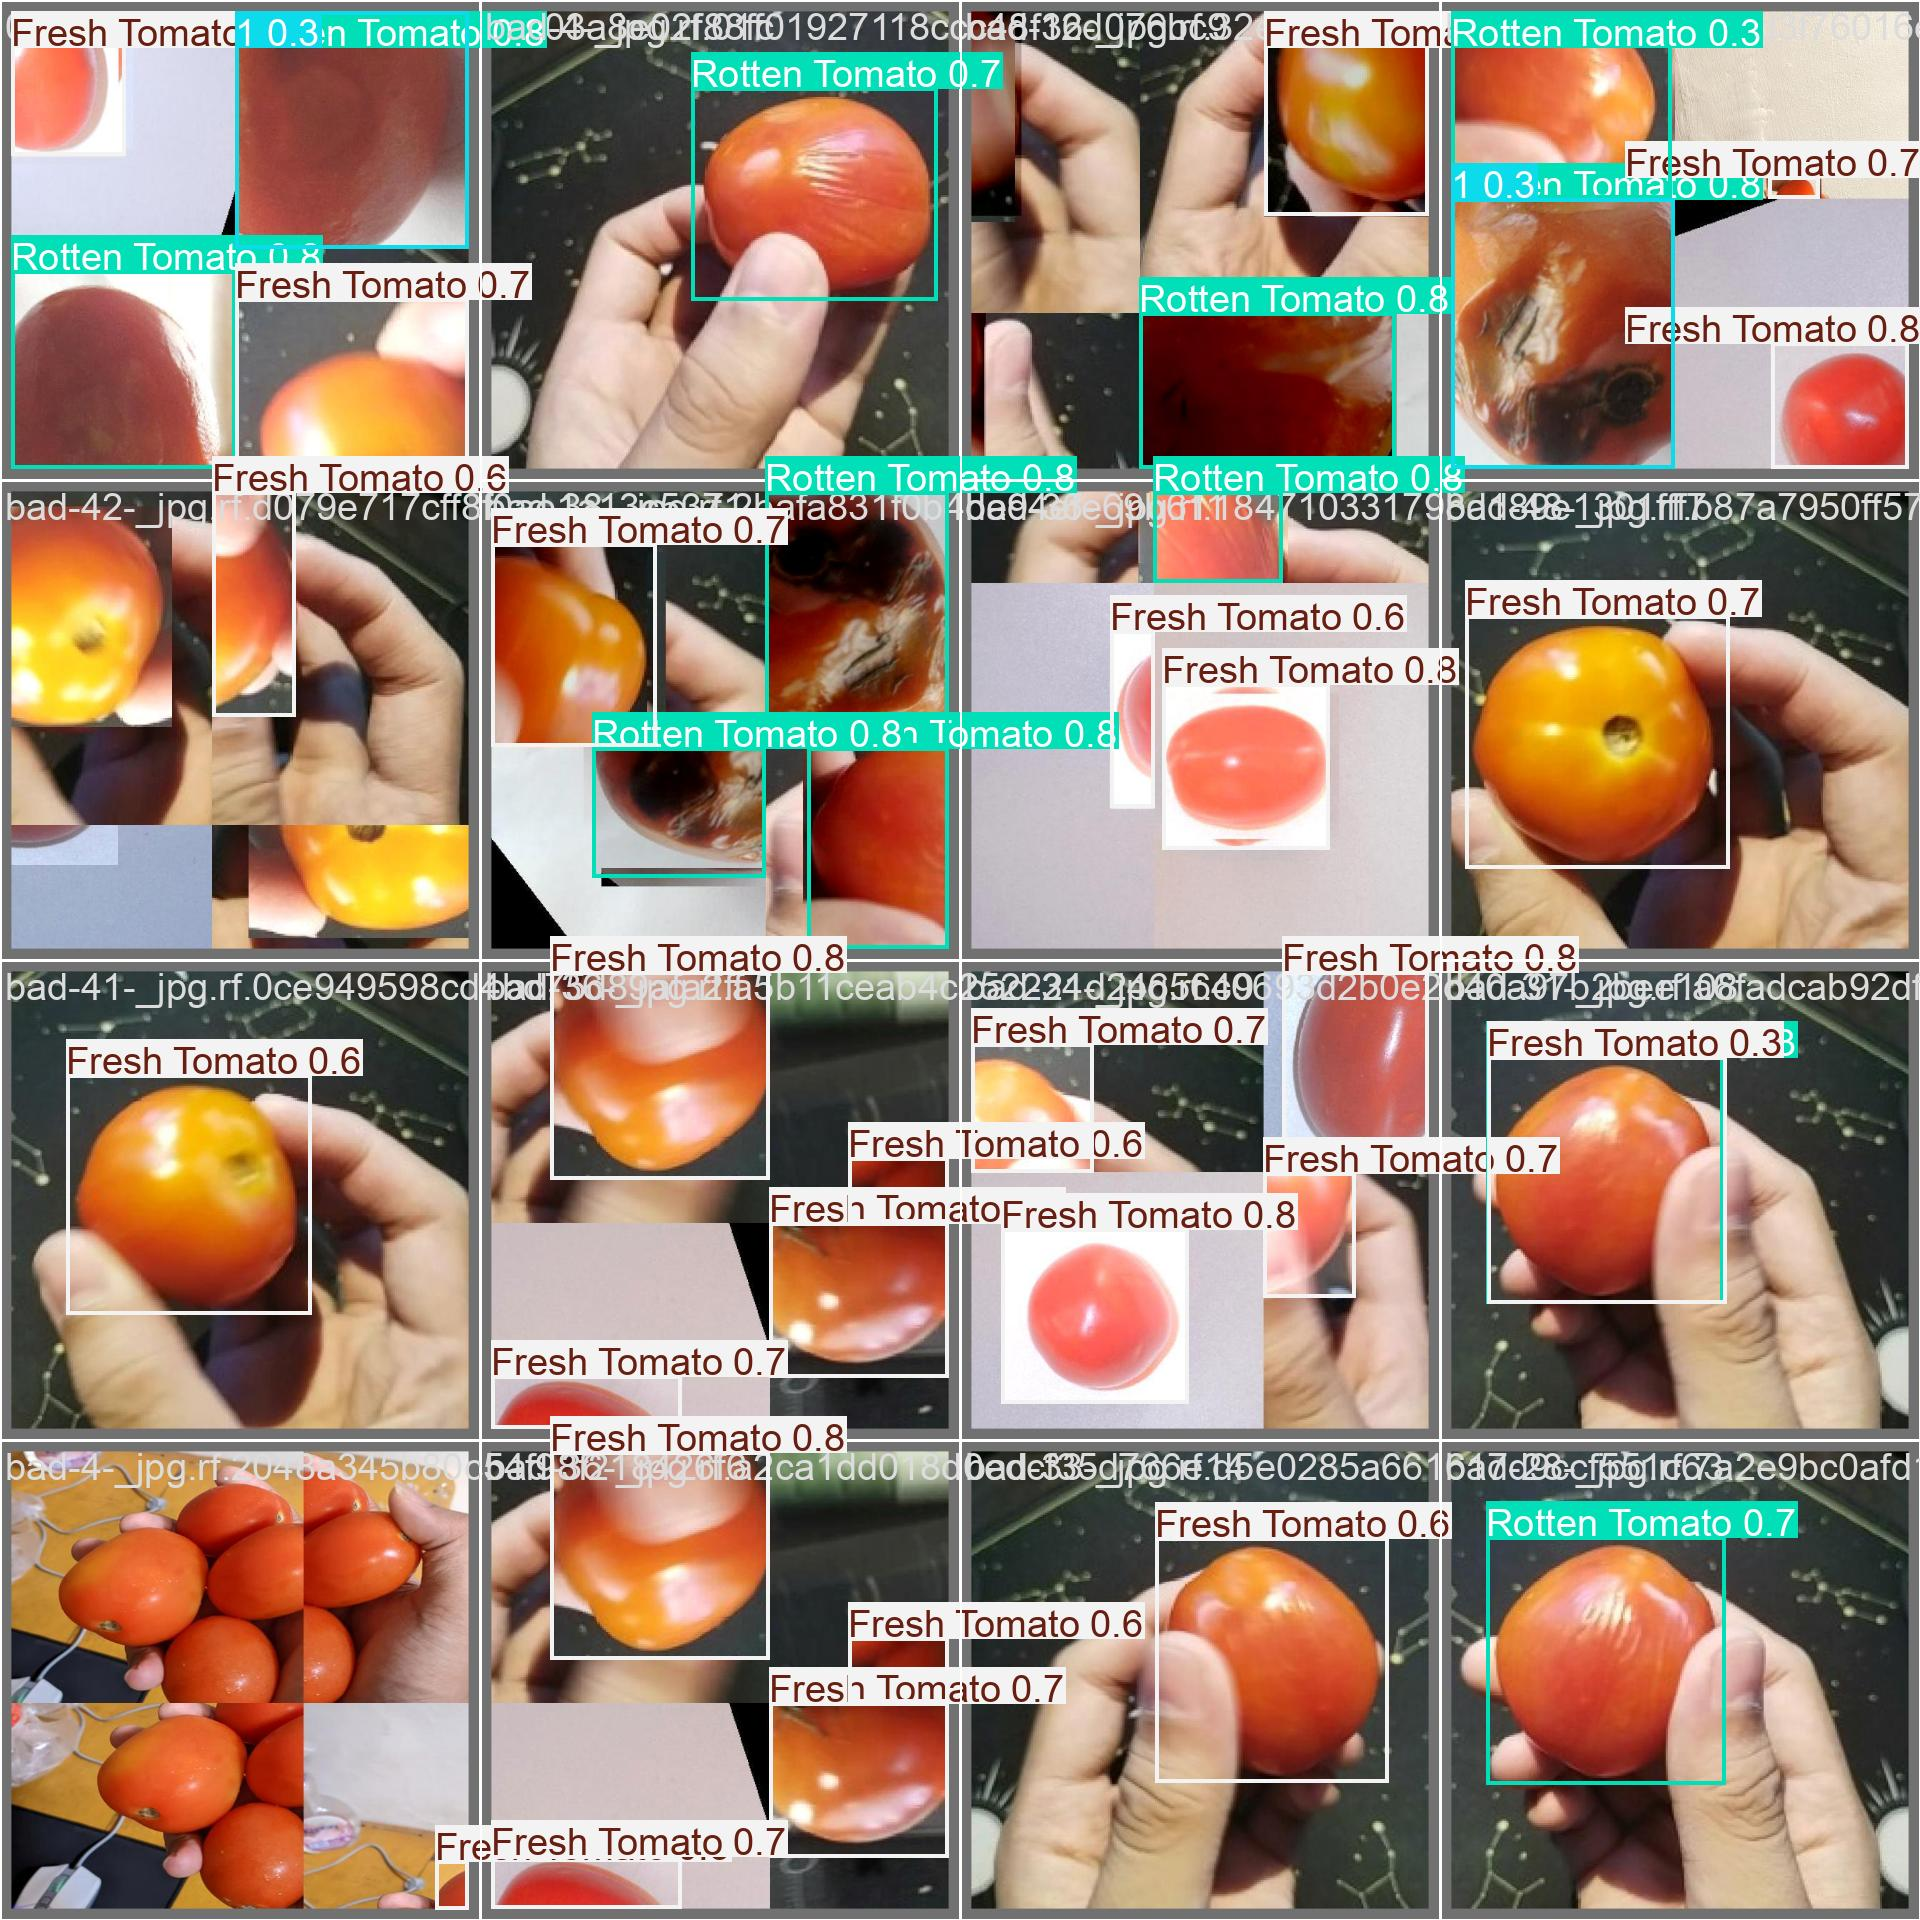

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

## Validate fine-tuned model

In [ ]:
!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml

Ultralytics 8.3.34 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11s summary (fused): 238 layers, 9,414,735 parameters, 0 gradients, 21.3 GFLOPs
val: Scanning /content/datasets/Tomato-Detection-Fresh-or-Rotten-using-YOLOv8-1/valid/labels.cache... 1969 images, 9 backgrounds, 0 corrupt: 100% 1969/1969 [00:00<?, ?it/s]
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 206, len(boxes) = 5121. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 124/124 [00:27<00:00,  4.48it/s]
                   all       1969       5121      0.568      0.746      0.404      0.384
                     0        347        709       0.21      0.882      0.211      0.198
                     1        250        368      0.199      0.938      0.218     

## Inference with custom model

In [ ]:
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

Ultralytics 8.3.34 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11s summary (fused): 238 layers, 9,414,735 parameters, 0 gradients, 21.3 GFLOPs

image 1/987 /content/datasets/Tomato-Detection-Fresh-or-Rotten-using-YOLOv8-1/test/images/001_jpg.rf.2c6caa773f57268c536aa58a1f38f2b3.jpg: 640x640 5 Fresh Tomatos, 15.6ms
image 2/987 /content/datasets/Tomato-Detection-Fresh-or-Rotten-using-YOLOv8-1/test/images/002_jpg.rf.a95a83efa76cbbc8ce7a0883681c9fe7.jpg: 640x640 6 Fresh Tomatos, 15.7ms
image 3/987 /content/datasets/Tomato-Detection-Fresh-or-Rotten-using-YOLOv8-1/test/images/009_jpg.rf.913bd13728fc3ab8e8760379c2e711f6.jpg: 640x640 2 Fresh Tomatos, 2 Rotten Tomatos, 15.6ms
image 4/987 /content/datasets/Tomato-Detection-Fresh-or-Rotten-using-YOLOv8-1/test/images/009_jpg.rf.fa415a8533e4098ccf78d84ba9d5f4cf.jpg: 640x640 1 Fresh Tomato, 15.5ms
image 5/987 /content/datasets/Tomato-Detection-Fresh-or-Rotten-using-YOLOv8-1/test/images/011_jpg.rf.3dddd5168296090fe68c606d366c9ec

**NOTE:** Let's take a look at few results.

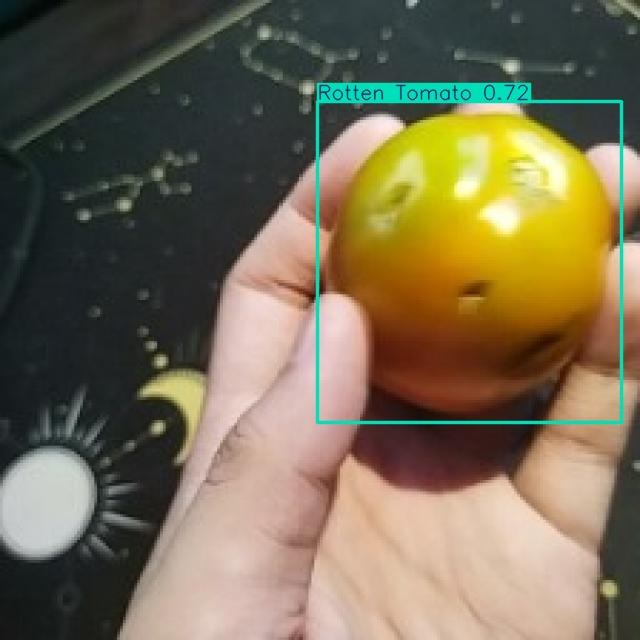

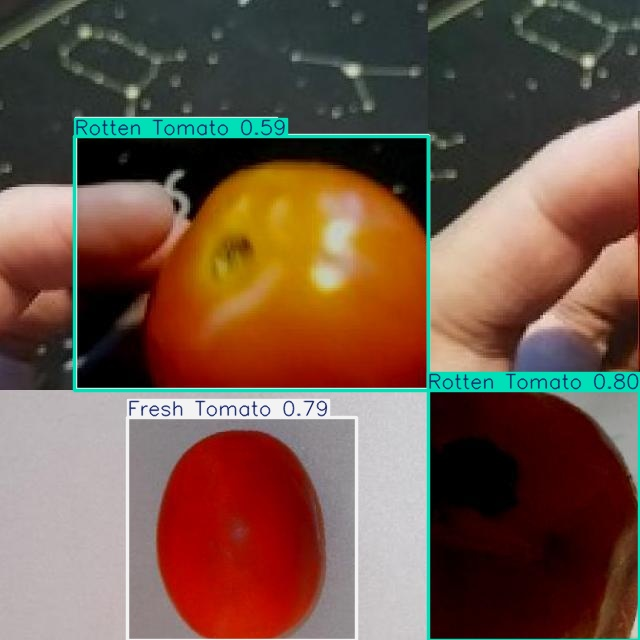

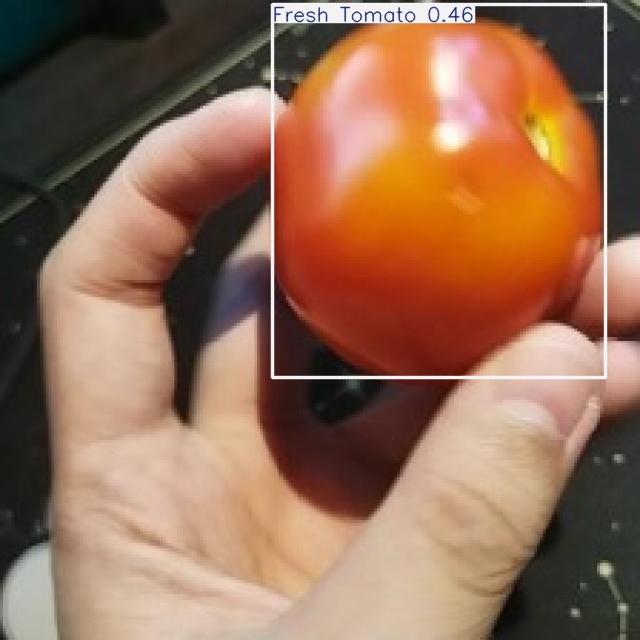

In [ ]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob('/content/runs/detect/predict*/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:3]:
    display(IPyImage(filename=img, width=600))
    print("\n")

Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
Specified provider 'OpenVINOExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
Specified provider 'CoreMLExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'


Running inference on good-215-_jpg.rf.4936632bb44460faae5a97ee9104c1f5.jpg


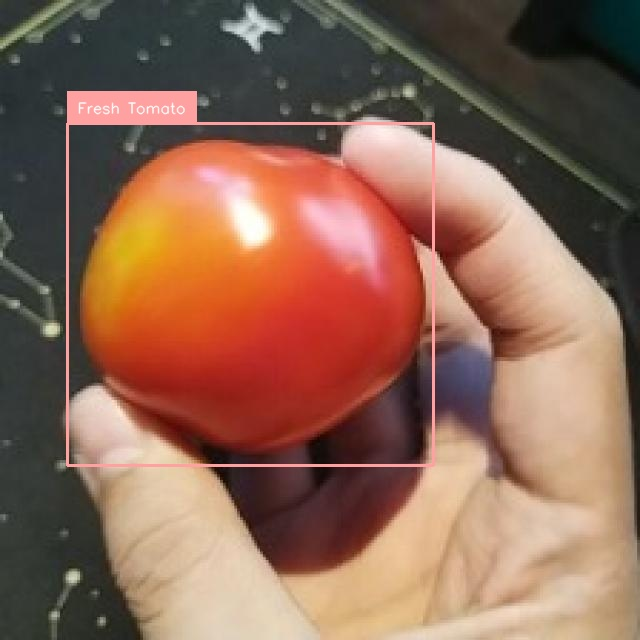

Running inference on 698_jpg.rf.bd1ebe48243b0ca044f8a7dbba1c50cc.jpg


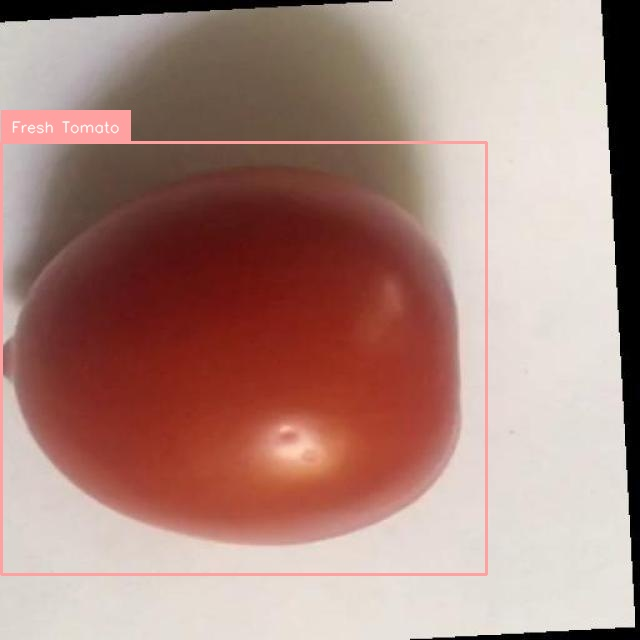

Running inference on bad-248-_jpg.rf.b9cb7a9439fc4a597d126fa014719e45.jpg


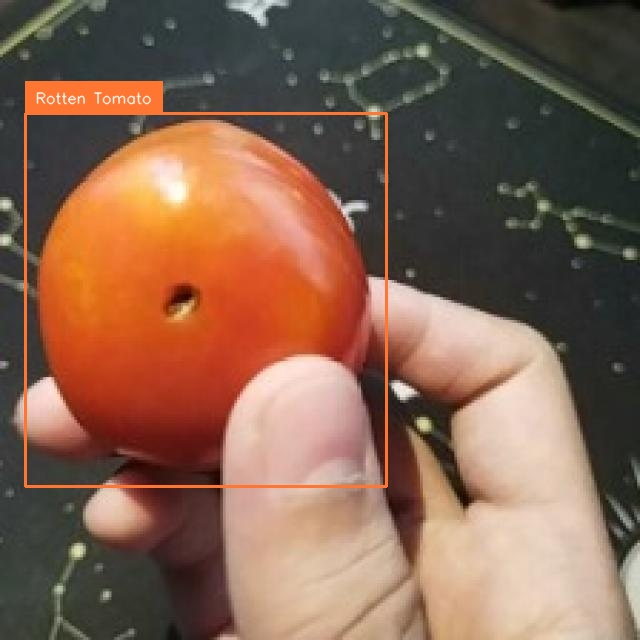

Running inference on very-bad-255-_jpg.rf.e9e1704c49c5c6aa3239849eb60210ae.jpg


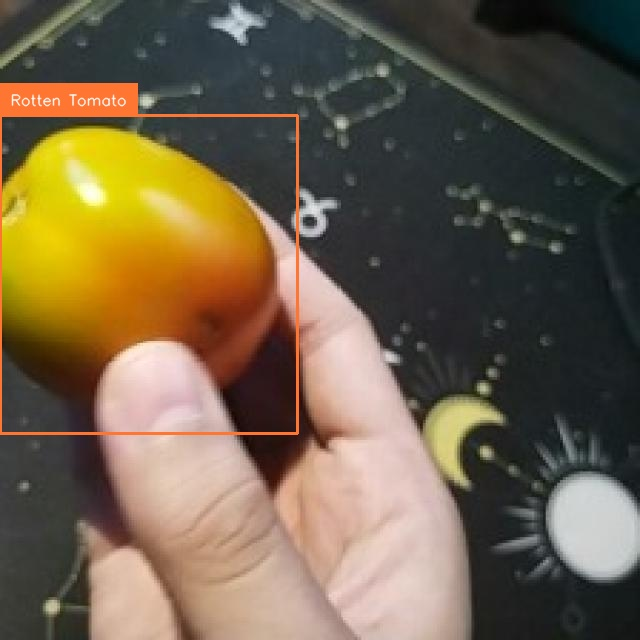

In [ ]:
import os, random, cv2
import supervision as sv
import IPython
import inference

model_id = project.id.split("/")[1] + "/" + dataset.version
model = inference.get_model(model_id, userdata.get('ROBOFLOW_API_KEY'))

# Location of test set images
test_set_loc = dataset.location + "/test/images/"
test_images = os.listdir(test_set_loc)

# Run inference on 4 random test images, or fewer if fewer images are available
for img_name in random.sample(test_images, min(4, len(test_images))):
    print("Running inference on " + img_name)

    # Load image
    image = cv2.imread(os.path.join(test_set_loc, img_name))

    # Perform inference
    results = model.infer(image, confidence=0.4, overlap=30)[0]
    detections = sv.Detections.from_inference(results)

    # Annotate boxes and labels
    box_annotator = sv.BoxAnnotator()
    label_annotator = sv.LabelAnnotator()
    annotated_image = box_annotator.annotate(scene=image, detections=detections)
    annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

    # Display annotated image
    _, ret = cv2.imencode('.jpg', annotated_image)
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)


Download The Results

In [ ]:
%cd /content/

/content


In [ ]:
!zip -r datasets.zip datasets


Streaming output truncated to the last 5000 lines.
  adding: datasets/Tomato-Detection-Fresh-or-Rotten-using-YOLOv8-1/train/images/1250_jpg.rf.c2b0586d990f543a30da75eb5b54bf5e.jpg (deflated 1%)
  adding: datasets/Tomato-Detection-Fresh-or-Rotten-using-YOLOv8-1/train/images/256_jpg.rf.2d8198a934eb54a3603305b0ad9e41b3.jpg (deflated 2%)
  adding: datasets/Tomato-Detection-Fresh-or-Rotten-using-YOLOv8-1/train/images/very-bad-161-_jpg.rf.57a96ee17555dc79702a810e1fe57f79.jpg (deflated 1%)
  adding: datasets/Tomato-Detection-Fresh-or-Rotten-using-YOLOv8-1/train/images/very-good-195-_jpg.rf.f859bd8ff8f294bed82d0e24637b56d3.jpg (deflated 1%)
  adding: datasets/Tomato-Detection-Fresh-or-Rotten-using-YOLOv8-1/train/images/669_jpg.rf.d3417ba46c0e8a57f89e7ab5f7934d0a.jpg (deflated 4%)
  adding: datasets/Tomato-Detection-Fresh-or-Rotten-using-YOLOv8-1/train/images/very-good-88-_jpg.rf.ac2617e1bae996eb680bcb62ab7a8ef9.jpg (deflated 1%)
  adding: datasets/Tomato-Detection-Fresh-or-Rotten-using-YOLOv8-

In [ ]:
!zip -r runs.zip runs


  adding: runs/ (stored 0%)
  adding: runs/detect/ (stored 0%)
  adding: runs/detect/predict/ (stored 0%)
  adding: runs/detect/predict/tomatoes-tomato-plant-Fruit-vegetable.jpg (deflated 4%)
  adding: runs/detect/train/ (stored 0%)
  adding: runs/detect/train/labels.jpg (deflated 20%)
  adding: runs/detect/train/train_batch2.jpg (deflated 10%)
  adding: runs/detect/train/events.out.tfevents.1732101617.c43e1d9ffc90.2446.0 (deflated 93%)
  adding: runs/detect/train/val_batch0_labels.jpg (deflated 9%)
  adding: runs/detect/train/confusion_matrix.png (deflated 26%)
  adding: runs/detect/train/val_batch0_pred.jpg (deflated 8%)
  adding: runs/detect/train/confusion_matrix_normalized.png (deflated 26%)
  adding: runs/detect/train/R_curve.png (deflated 10%)
  adding: runs/detect/train/val_batch2_labels.jpg (deflated 7%)
  adding: runs/detect/train/train_batch1.jpg (deflated 9%)
  adding: runs/detect/train/PR_curve.png (deflated 13%)
  adding: runs/detect/train/val_batch1_labels.jpg (deflated 